# Machine Learning portfolio opdracht 3

Teamnaam: Ongeneeselijk muziekaal

Teamleden:
1. needanku (Tijn)
2. jipschijvenaars (Jip)
3. joesvandeursen (Joes)
4. jimaugustinus (Jim)


#### Import libraries

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from IPython.display import Audio, display
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from 
from sklearn.decomposition import PCA, NMF
from sklearn.datasets import make_blobs


fromfrom sklearn.preprocessing import MinMaxScaler

# Opdracht 1. Feature enginering

#### Data laden en verkennen

In [38]:
labels_df = pd.read_csv('labels_new.csv')
display(labels_df.head())

,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


In [39]:
print("Verdeling Genres:")
print("-" * 17)
print(labels_df['genre'].value_counts())
print("\nTotaal aantal samples:", len(labels_df))
print("Aantal verschillende genres:", labels_df['genre'].nunique())

Verdeling Genres:
-----------------
genre
metal        5
country      5
hiphop       5
reggae       5
classical    5
jazz         5
rock         5
pop          5
blues        5
disco        5
Name: count, dtype: int64

Totaal aantal samples: 50
Aantal verschillende genres: 10


In [40]:
labeled_audio_dir = Path('labeled')
labeled_audio_files = os.listdir(labeled_audio_dir)

## Een dataframe met audiofeatures


In [ ]:
class AudioFeatureExtractor:
    """ A class to get librosa audio features from all files in a folder and merge them with a dataframe

    Methods
    -------
    extract_features(audio_files) :
        specifies the audio files on which the process_file function is used
    process_file(file_path, filename) :
        function which extracts librosa audio features from an audio file
    merge_with_labels(labels_df) :
        merges the result of extracts_features
    """
    def __init__(self, audio_dir):
        """ constructs the basic items for audio extraction
        
        Parameters
        ----------
        audio_dir : str
            name of the folder cantaining audio files
        """
        self.audio_dir = Path(audio_dir)
        self.features_list = []
        
    def extract_features(self, audio_files):
        """ specifies the audio files on which the process_file function is used
        
        Parameters
        ----------
        audio_files : str
            name of folder containing audio files

        Returns
        -------
        DataFrame
            a df containing the features of all files in the specified folder
        """
        for filename in audio_files:
            file_path = self.audio_dir / filename
            features = self.process_file(file_path, filename)
            self.features_list.append(features)
        return pd.DataFrame(self.features_list)
    
    def process_file(self, file_path, filename):
        """ function which extracts librosa audio features from an audio file
        
        Parameters
        ----------
        file_path : str
            name of folder containing audio files
        filename : str
            name of audio file

        Returns
        -------
        Dictionary
            a dict containing the features extracted from a audio file
        """
        y, sr = librosa.load(file_path)
        
        # https://librosa.org/doc/latest/feature.html
        features = {
            'filename': filename,
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'spectral_bandwidth_std': np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'spectral_centroid_std': np.std(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)),
            'zero_crossing_rate_std': np.std(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y)),
            'rms_std': np.std(librosa.feature.rms(y=y)),
            'rolloff': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            'flatness': np.mean(librosa.feature.spectral_flatness(y=y)),
            'tempo': librosa.beat.tempo(y=y, sr=sr)[0]
        }
        
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
        features.update({
            'onset_strength_mean': np.mean(onset_env),
            'onset_strength_std': np.std(onset_env),
            'beat_strength': np.mean(librosa.util.normalize(onset_env)[beats]) if len(beats) > 0 else 0
        })
        
        harmonic, percussive = librosa.effects.hpss(y)
        features.update({
            'harmonic_ratio': np.mean(np.abs(harmonic)) / (np.mean(np.abs(percussive))),
            'percussive_ratio': np.mean(np.abs(percussive)) / (np.mean(np.abs(harmonic)))
        })
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}'] = np.mean(mfcc[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])
        
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(12):
            features[f'chroma_{i+1}'] = np.mean(chroma[i])
            features[f'chroma_{i+1}_std'] = np.std(chroma[i])
        
    
        tempogram = librosa.feature.tempogram(y=y, sr=sr)
        features.update({
            'tempogram_ratio': np.mean(tempogram) / (np.std(tempogram)),
            'tempogram_std': np.std(tempogram)
        })
        
        return features
    
    def merge_with_labels(self, labels_df):
        """ merges the result of extracts_features
        
        Parameters
        ----------
        labels_df : df
            name of df which will be merged

        Returns
        -------
        DataFrame
            new df containing the merged data
        """
        features_df = pd.DataFrame(self.features_list)
        return pd.merge(features_df, labels_df, on='filename')

extractor = AudioFeatureExtractor(labeled_audio_dir)
features_df = extractor.extract_features(labeled_audio_files)
audio_features_df = extractor.merge_with_labels(labels_df)

display(audio_features_df.head())


C:\Users\USER\AppData\Local\Temp\ipykernel_22040\4149447631.py:55: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0]


,filename,spectral_bandwidth,spectral_bandwidth_std,spectral_centroid,spectral_centroid_std,zero_crossing_rate,zero_crossing_rate_std,rms,rms_std,rolloff,...,chroma_9_std,chroma_10,chroma_10_std,chroma_11,chroma_11_std,chroma_12,chroma_12_std,tempogram_ratio,tempogram_std,genre
0,m00002.wav,1920.270843,352.469828,1451.862124,428.935223,0.051224,0.025074,0.050480,0.027131,3047.431199,...,0.377096,0.287583,0.328681,0.224478,0.326612,0.185700,0.306980,0.869013,0.200426,jazz
1,m00039.wav,2019.300257,442.196748,1811.410394,809.772584,0.072150,0.051697,0.123665,0.053056,3854.851374,...,0.223918,0.297682,0.275615,0.422818,0.337206,0.401892,0.297101,0.747660,0.139721,reggae
2,m00041.wav,2992.010638,346.836989,3110.898196,779.418888,0.152857,0.068744,0.198322,0.077807,6744.988603,...,0.323897,0.332073,0.237859,0.445475,0.354692,0.293710,0.220588,0.802305,0.187328,pop
3,m00072.wav,2709.897108,360.419232,2624.814629,585.287392,0.120217,0.038883,0.142927,0.062914,5605.777240,...,0.329127,0.282717,0.175517,0.376277,0.294601,0.277690,0.236222,0.806668,0.193607,disco
4,m00096.wav,2485.524548,368.525304,2549.269757,695.078336,0.115834,0.050427,0.184340,0.098477,5583.144894,...,0.298731,0.244928,0.281050,0.239062,0.275884,0.318006,0.307679,0.729187,0.165431,disco


In [43]:
audio_features_df.columns

Index(['filename', 'spectral_bandwidth', 'spectral_bandwidth_std',
       'spectral_centroid', 'spectral_centroid_std', 'zero_crossing_rate',
       'zero_crossing_rate_std', 'rms', 'rms_std', 'rolloff', 'flatness',
       'tempo', 'onset_strength_mean', 'onset_strength_std', 'beat_strength',
       'harmonic_ratio', 'percussive_ratio', 'mfcc_1', 'mfcc_1_std', 'mfcc_2',
       'mfcc_2_std', 'mfcc_3', 'mfcc_3_std', 'mfcc_4', 'mfcc_4_std', 'mfcc_5',
       'mfcc_5_std', 'mfcc_6', 'mfcc_6_std', 'mfcc_7', 'mfcc_7_std', 'mfcc_8',
       'mfcc_8_std', 'mfcc_9', 'mfcc_9_std', 'mfcc_10', 'mfcc_10_std',
       'mfcc_11', 'mfcc_11_std', 'mfcc_12', 'mfcc_12_std', 'mfcc_13',
       'mfcc_13_std', 'chroma_1', 'chroma_1_std', 'chroma_2', 'chroma_2_std',
       'chroma_3', 'chroma_3_std', 'chroma_4', 'chroma_4_std', 'chroma_5',
       'chroma_5_std', 'chroma_6', 'chroma_6_std', 'chroma_7', 'chroma_7_std',
       'chroma_8', 'chroma_8_std', 'chroma_9', 'chroma_9_std', 'chroma_10',
       'chroma_10_st

Feature Extraction (2025, 9 maart) Librosa. https://librosa.org/doc/latest/feature.html

## Spectrale features
1. **`spectral_bandwidth`**:
   - **Betekenis**: Meet de breedte van de frequentiebanden rondom het "centrum" van het spectrum. Het geeft aan hoeveel frequenties variëren rond de dominante frequentie.
   - **Bepaling**: Het gemiddelde van de breedte wordt berekend over het gehele audiofragment.

2. **`spectral_bandwidth_std`**:
   - **Betekenis**: De standaarddeviatie van de frequentiebandbreedte, waarmee de variatie in de bandbreedte wordt aangegeven.
   - **Bepaling**: Variatie in bandbreedte van het gehele audiofragment.

3. **`spectral_centroid`**:
   - **Betekenis**: Het "zwaartepunt" van het frequentiespectrum. Dit geeft aan welke frequentie dominant is in het geluid. Een hogere waarde duidt op een helderder geluid, terwijl een lagere waarde meer bass-achtig is.
   - **Bepaling**: Gemiddelde van de spectrale centroidwaarden over het gehele audiofragment.

4. **`spectral_centroid_std`**:
   - **Betekenis**: De variatie van de spectrale centroid, laat zien hoe de variatie van het zwaartepunt is.
   - **Bepaling**: Standaarddeviatie van de spectrale centroidwaarden.

5. **`zero_crossing_rate`**:
   - **Betekenis**: Hoe vaak het audiosignaal de nul-as kruist per seconde. 
   - **Bepaling**: Gemiddelde nulovergangen per audiofragment.

6. **`zero_crossing_rate_std`**:
   - **Betekenis**: variatie van de 'zero-crossing rate'.
   - **Bepaling**: Standaarddeviatie van het aantal nulovergangen.

7. **`rms`**:
   - **Betekenis**: De gemiddelde energie van het geluid. Geeft het volume van het signaal weer.
   - **Bepaling**: Gemiddelde van de wortel van het gemiddelde in het kwadraat van de energie (Root Mean Square).

8. **`rms_std`**:
   - **Betekenis**: variatie van de amplitude-energie.
   - **Bepaling**: Standaarddeviatie van RMS over het audiofragment.

9. **`rolloff`**:
   - **Betekenis**: De frequentie waaronder een bepaald percentage van de totale energie ligt.
   - **Bepaling**: Gemiddelde van rolloff-waarden van het audiofragment.

10. **`flatness`**:
    - **Betekenis**: Meet hoe plat het frequentiespectrum is. Hoge waarden betekenen dus een gelijkwaardige verdeling.
    - **Bepaling**: Gemiddelde spectrale vlakheid.

## Ritme features
11. **`tempo`**:
    - **Betekenis**: De gemiddelde snelheid van het ritme in beats per minute (BPM).
    - **Bepaling**: Geschat op basis van beat tracking en onset detectie.

12. **`onset_strength_mean`**:
    - **Betekenis**: De gemiddelde sterkte van de beginpunten (onsets) in het audiofragment. Hogere waarden betekenen sterkere beats.
    - **Bepaling**: Gemiddelde sterkte van onset detectie.

13. **`onset_strength_std`**:
    - **Betekenis**: Variatie in onset sterkte, wat aangeeft hoe consistent het ritme is.
    - **Bepaling**: Standaarddeviatie van onset sterkte.

14. **`beat_strength`**:
    - **Betekenis**: Meet de sterkte van de beats. Een hogere waarde wijst op sterkere, meer gedefinieerde ritmes.
    - **Bepaling**: Gemiddelde sterkte van beats.

15. **`harmonic_ratio`**:
    - **Betekenis**: De verhouding van harmonische energie tot percussieve energie. Hogere waarden wijzen op een harmonieus signaal.
    - **Bepaling**: Gemiddelde amplitude van het harmonische signaal gedeeld door die van het percussieve signaal.

16. **`percussive_ratio`**:
    - **Betekenis**: De verhouding van percussieve energie tot harmonische energie.
    - **Bepaling**: Omgekeerde van harmonische ratio.

## Spectrale features
17. **`mfcc_1` tot `mfcc_13`**:
    - **Betekenis**: Lage MFCC's vertegenwoordigen de algemene vorm van het frequentiespectrum, terwijl hogere MFCC's details zoals toon en textuur weergeven.
    - **Bepaling**: Gemiddelde waarde van elk MFCC-coëfficiënt.

18. **`mfcc_1_std` tot `mfcc_13_std`**:
    - **Betekenis**: Variatie van elke MFCC-coëfficiënt. 
    - **Bepaling**: Standaarddeviatie van elk MFCC-coëfficiënt.

19. **`chroma_1` tot `chroma_12`**:
    - **Betekenis**: Gemiddelde energieverdeling over de 12 tonen (van een octaaf). Chroma toont hoe vaak elke toon aanwezig is in het geluid.
    - **Bepaling**: Gemiddelde chroma-component per toon.

20. **`chroma_1_std` tot `chroma_12_std`**:
    - **Betekenis**: Variatie van chroma-componenten.
    - **Bepaling**: Standaarddeviatie per chroma-component.

## Ritme features
21. **`tempogram_ratio`**:
    - **Betekenis**: Gemiddelde verhouding van de tempogramwaarden.
    - **Bepaling**: Gemiddelde van de tempogramwaarden gedeeld door hun standaarddeviatie.

22. **`tempogram_std`**:
    - **Betekenis**: Variatie in de periodiciteit van het ritme.
    - **Bepaling**: Standaarddeviatie van tempogramwaarden.


Feature Extraction (2025, 9 maart) Librosa. https://librosa.org/doc/latest/feature.html

# Opdracht 2: Unsupervised Learning

In [44]:
unlabeled_audio_dir = Path('unlabeled')
unlabeled_audio_files = os.listdir(unlabeled_audio_dir)

In [45]:
unlabeled_df = pd.DataFrame(os.listdir(unlabeled_audio_dir))

## Bepalen aantal clusters

C:\Users\USER\AppData\Local\Temp\ipykernel_22040\4149447631.py:55: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0]
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.

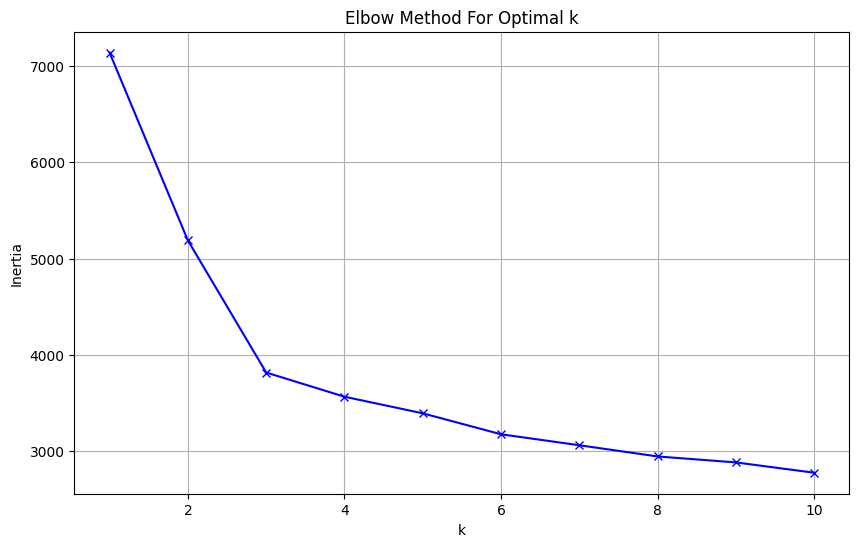

In [46]:
unlabeled_extractor = AudioFeatureExtractor(unlabeled_audio_dir)
unlabeled_features = unlabeled_extractor.extract_features(unlabeled_audio_files)

X = unlabeled_features.drop('filename', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [47]:
inertias

[7140.0,
 5188.172560899599,
 3815.466044978106,
 3564.0442749996746,
 3391.4096335422496,
 3173.5133674575836,
 3059.58392179536,
 2943.0164060617553,
 2881.118933837909,
 2773.961251841246]

Om te bepalen hoeveel clusters er in de dataset zitten gebruiken wij de 'Elbow-method'. Voor het gebruik van deze methode moeten wij een aantal stappen doorlopen die hier stap voor stap worden uitgelegd.

1. Schalen van de data: Bij het clusteren van data wordt vaak gewerkt met afstanden tussen datapunten. Omdat afstanden erg gevoelig zijn voor niet geschaalde data, is het belangrijk dat de data eerst geschaald wordt voordat wij hier verder mee gaan werken.

2. Uitvoeren van een clustering-algoritme: Vervolgens wordt een clusterings-algoritme (in dit geval K-means) uitgevoerd voor een aantal waarden van *k* (in dit geval 1 tot 10).

3. Bepalen van de inertia waarden: Inertia is een maatstaf voor hoe goed het clusterings-algoritme een dataset heeft gegroepeerd. Inertia meet de som van de kwadratische afstanden van elk datapunt tot de dichtstbijzijnde centroid (centrum van de cluster). Hoe lager de inertia, hoe compacter de clusters zijn. Wij bepalen hier de waarde van de inertia voor alle bijbehorenden waarden *k*

4. Elbow-plot maken: Door de intertia te plotten tegenover de bijbehorende waarde van *k* kunnen wij duidelijk de verandering zien van de intertia wanneer het aantal clusters toeneemt.

5. Bepalen optimale k-waarde: Het kiezen van de optimale waarde van k wordt gedaan door te kijken waar de elbow-plot afvlakt. Wanneer deze plot afvlakt, betekend dit dat de afname van de inertia minder significant wordt. In andere woorden kan gezegd worden dat het toevoegen van extra clusters na dit punt weinig voordeel meer heeft en dus de optimale waarde van *k* is gevonden.

Uit de analyse van onze elbow-method blijkt dat hier de optimale waarde van *k* wordt gevonden bij 3. Er zitten dus 3 clusters in de 'unlabeled' dataset.

Lesmateriaal - 24/25 Machine Learning FALL_SEM1. (2025, 9 maart). Brightspace https://brightspace.hhs.nl/d2l/le/lessons/102168/units/874356

## Onderzoek 3 clustering algoritmes

Bij het uitleggen van de werking voor de clusters wordt er al vanuit gegaan dat het optimale aantal clusters al is berekend. In ons geval wordt er gewerkt met 3 clusters (k=3)

### *K-means clustering*

**Werking**

Hieronder wordt stap voor stap uitgelegd hoe K-means clustering werkt. 

1. Kiezen van centroids: Allereerst worden er *k* willekeurige centroids gekozen. In ons geval wordt er gekozen voor 3 centroids.

2. Datapunten toewijzen aan centroids: Vervolgens wordt er voor elk datapunt in de dataset gekeken welke centroid het dichts bij ligt. Dit wordt gedaan op basis van de *Euclidische afstand*. De formule van de euclidische afstand is alsvolgt:

    $d(x_i, c_j)$=$\sqrt{\sum_{f=1}^{F} (x_{if} - c_{jf})^2}$

    waarbij:
    - $d(x_i, c_j)$ : afstand van punt x tot centroid c
    - $F$ : aantal dimensies
    - $x_{if}$ : waarde van het kenmerk f van het datapunt x
    - $c_{jf}$ : waarde van het f kenmerk van de centroid c
    - ${\sum_{f=1}^{F}}$ : som van alle verschillen over alle dimensies $F$

3. Berekenen nieuwe centroids: Ten derde worden opnieuw de centroids berekend. Dit wordt gedaan door het gemiddelde te nemen van alle punten die aan het cluster van de desbetreffende centroid zijn toegewezen.

4. Herhaal stap 2 en 3: Als laatste wordt stap 2 en 3 steeds opnieuw herhaald. Dit wordt gedaan totdat de centroids niet meer significant veranderen. Dit wil zeggen dat de veranderingen zo klein zijn dat dit (bijna) niks meer toevoegd aan de analyse.

GeeksforGeeks. (2025, 15 januari). K means Clustering Introduction. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-clustering-introduction/ 

Lesmateriaal - 24/25 Machine Learning FALL_SEM1. (2025, 9 maart). Brightspace https://brightspace.hhs.nl/d2l/le/lessons/102168/units/874356



### *Hierargische clustering*

**Werking**

Hieronder wordt stap voor stap uitgelegd hoe hierargisch clusteren werkt. 

1. Afzonderlijke clusters: Als eerste begint elk datapunt als een afzonderlijk cluster.

2. Afstand bepalen: Vervolgens wordt de afstand tussen alle combinaties van 2 clusters berekend. Dit kan weer gedaan worden met de eerder uitgelegde 'Euclidische afstand'

3. Kies een koppelingsmethode: Er zijn verschillende koppelingsmethoden bij het gebruik van hierargische clustering. Deze zijn:
    1. Single linkage/Min distance; afstand tussen de dichtsbijzijnde punten van 2 clusters
    2. Complete linkage/Max distance; afstande tussen de verste punten van 2 clusters
    3. Average linkage/Group average; gemiddelde afstand tussen alle paren van datapunten

4. Combineren: Op basis van de gekozen koppelingsmethode worden de 2 dichtsbijzijnde clusters gecombineerd tot 1 cluster.

5. Herhalen: deze stappen worden herhaald totdat er uiteindelijk de gewenste aantal clusters overblijven, k=3.


GeeksforGeeks. (2025, 4 februari). Hierarchical clustering in machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/hierarchical-clustering/

Lesmateriaal - 24/25 Machine Learning FALL_SEM1. (2025, 9 maart). Brightspace https://brightspace.hhs.nl/d2l/le/lessons/102168/units/874356

### *DBSCAN*

**Werking**

Hieronder wordt stap voor stap uitgelegd hoe DBSCAN werkt.

1. Bepaal de instellingen:
Kiezen van twee belangrijke parameters:

    - Epsilon ($\epsilon$): Dit is de maximale afstand waarbinnen punten nog als “buren” worden gezien.
    - MinSamples: Het minimum aantal punten dat nodig is om een groep te beschouwen als een cluster.

2. Vaststellen belangrijke punten:
Voor elk datapunt wordt gekeken hoeveel andere punten binnen de straal 
$\epsilon$ liggen.
Als er genoeg punten (MinSamples) in de buurt zijn, wordt dat punt een kernpunt genoemd.
Liggen er niet genoeg punten in de buurt? In dat geval wordt het punt een randpunt genoemd of in sommige gevallen genegeerd als ruis.

3. Clusters bouwen:
Het algoritme begint bij een kernpunt en maakt daar een cluster van. Daarna zoekt het alle punten binnen de straal 
$\epsilon$ rondom dat kernpunt en voegt die toe aan het cluster. 
Vindt het onderweg nieuwe kernpunten? Dan wordt het cluster verder uitgebreid met het nieuwe kernpunt en zijn buren.

4. Markeren ruis:
Punten die geen kernpunt zijn en niet bij een cluster horen, worden gemarkeerd als ruis. Deze punten worden genegeerd in de uiteindelijke clustering.

5. Clusters afronden:
Dit proces van kernpunten zoeken en clusters uitbreiden herhaalt zich totdat alle punten zijn beoordeeld. De clusters zijn af zodra er geen nieuwe kernpunten meer gevonden worden.


GeeksforGeeks. (2025, 29 januari). DBSCAN Clustering in ML | Density based clustering. GeeksforGeeks. https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/ 

### Gekozen clusteringsmethode

Wij hebben ervoor gekozen om K-means clustering te gebruiken. Dit algoritme is het meest geschik voor ons probleem omdat wij met een grote dataset werken. K-means is snel en efficiënt bij het gebruik van grote dataset wat deze dus ideaal maakt voor onze situatie. Daarnaast werkt K-means clustering goed bij bolvormige clusters. Omdat wij verwachten bolvormige clusters te gebruiken lijkt dit de meest geschikte optie. Als laatste is dit modelijk makkelijk om te maken en ook eenvoudig om te begrijpen. Om al deze eerder genoemde redenen hebben wij ervoor gekozen om K-means clustering te gebruiken.

## Uitvoeren gekozen clusteringsalgoritme

In [61]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

unlabeled_features['cluster'] = clusters

display(unlabeled_features)

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,filename,spectral_bandwidth,spectral_bandwidth_std,spectral_centroid,spectral_centroid_std,zero_crossing_rate,zero_crossing_rate_std,rms,rms_std,rolloff,...,chroma_9_std,chroma_10,chroma_10_std,chroma_11,chroma_11_std,chroma_12,chroma_12_std,tempogram_ratio,tempogram_std,cluster
0,m00003.wav,2071.028440,256.021413,2254.606986,426.010685,0.120116,0.038432,0.136221,0.037759,4381.532206,...,0.248429,0.488607,0.288612,0.486308,0.210546,0.662977,0.293953,0.805318,0.180113,1
1,m00012.wav,2286.252592,246.334701,2908.300131,392.188778,0.178108,0.041937,0.217475,0.035082,5405.816551,...,0.249538,0.423689,0.273221,0.311572,0.206197,0.326612,0.220045,0.893226,0.262532,1
2,m00013.wav,1865.996047,150.084577,1952.607933,407.590792,0.123423,0.047069,0.029083,0.018222,3779.909832,...,0.134622,0.517787,0.351270,0.310177,0.330208,0.168636,0.155494,0.838954,0.182392,2
3,m00043.wav,2072.759900,343.662917,2384.634958,517.703205,0.126073,0.044940,0.100411,0.022301,4584.132502,...,0.241416,0.380119,0.239142,0.425498,0.237476,0.526869,0.315568,0.803270,0.183209,1
4,m00044.wav,900.409298,210.772748,790.507005,180.089642,0.052088,0.019098,0.018833,0.012053,1159.412273,...,0.361207,0.227969,0.222217,0.408830,0.395656,0.159130,0.186154,0.864133,0.195527,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,m00971.wav,1588.217850,446.341219,1525.791709,459.815904,0.091590,0.029151,0.038885,0.020145,2733.184659,...,0.164612,0.321060,0.281911,0.297440,0.260275,0.206007,0.183071,0.854350,0.216650,2
101,m00973.wav,3295.063699,333.732126,3669.810467,938.109519,0.161797,0.084655,0.259782,0.096068,7876.372739,...,0.224745,0.464613,0.307356,0.370504,0.237649,0.434134,0.322912,0.799756,0.186873,0
102,m00988.wav,3361.641125,313.312735,3941.417697,1162.771631,0.167480,0.134007,0.240724,0.130481,8260.423162,...,0.327118,0.570102,0.340334,0.523319,0.320810,0.551307,0.327573,0.765879,0.147697,0
103,m00991.wav,1404.408040,157.296757,983.971719,217.044324,0.044217,0.018599,0.017138,0.006726,1853.129475,...,0.334545,0.256195,0.266501,0.398029,0.340729,0.200507,0.239316,0.903674,0.327978,2


## Werking K-means

#### **Werking K-means**

Hieronder wordt stap voor stap uitgelegd hoe K-means clustering werkt. 

1. Kiezen van centroids: Allereerst worden er *k* willekeurige centroids gekozen. In ons geval wordt er gekozen voor 3 centroids.

2. Datapunten toewijzen aan centroids: Vervolgens wordt er voor elk datapunt in de dataset gekeken welke centroid het dichts bij ligt. Dit wordt gedaan op basis van de *Euclidische afstand*. De formule van de euclidische afstand is alsvolgt:

    $d(x_i, c_j)$=$\sqrt{\sum_{f=1}^{F} (x_{if} - c_{jf})^2}$

    waarbij:
    - $d(x_i, c_j)$ : afstand van punt x tot centroid c
    - $F$ : aantal dimensies
    - $x_{if}$ : waarde van het kenmerk f van het datapunt x
    - $c_{jf}$ : waarde van het f kenmerk van de centroid c
    - ${\sum_{f=1}^{F}}$ : som van alle verschillen over alle dimensies $F$

3. Berekenen nieuwe centroids: Ten derde worden opnieuw de centroids berekend. Dit wordt gedaan door het gemiddelde te nemen van alle punten die aan het cluster van de desbetreffende centroid zijn toegewezen.

4. Herhaal stap 2 en 3: Als laatste wordt stap 2 en 3 steeds opnieuw herhaald. Dit wordt gedaan totdat de centroids niet meer significant veranderen. Dit wil zeggen dat de veranderingen zo klein zijn dat dit (bijna) niks meer toevoegd aan de analyse.

#### **Voorbeeld**

##### **Stap 1: Dataset**
We hebben een dataset met vier punten in een 2D-ruimte:

| Punt | \( x \) | \( y \) |
|------|----|----|
| A    | 2  | 3  |
| B    | 3  | 3  |
| C    | 8  | 7  |
| D    | 9  | 6  |

We kiezen \( K = 2 \), wat betekent dat we twee clusters willen vinden.

##### **Stap 2: Kiezen centroids**
We selecteert twee willekeurige punten als centroids. In dit geval kiezen we:

- **Centroid 1**: \( (2,3) \) (gelijk aan punt A)
- **Centroid 2**: \( (9,6) \) (gelijk aan punt D)

##### **Stap 3: Toewijzen van punten aan de dichtstbijzijnde centroid**
Voor elk punt berekenen we de Euclidische afstand tot beide centroids en wijzen het toe aan de dichtstbijzijnde:

- Punt A en B liggen dichter bij Centroid 1 → **Cluster 1**  
- Punt C en D liggen dichter bij Centroid 2 → **Cluster 2**  

##### **Stap 4: Herberekenen van centroids**
Voor elk cluster berekenen we het nieuwe gemiddelde van de punten in dat cluster:

- **Nieuwe Centroid 1**: Gemiddelde van (2,3) en (3,3) → \( (2.5, 3) \)  
- **Nieuwe Centroid 2**: Gemiddelde van (8,7) en (9,6) → \( (8.5, 6.5) \)  

##### **Stap 5: Herhalen**
Het proces van toewijzen en herberekenen wordt herhaald totdat de centroids niet meer veranderen.

- **Cluster 1**: (2,3), (3,3)  
- **Cluster 2**: (8,7), (9,6)  

Lesmateriaal - 24/25 Machine Learning FALL_SEM1. (2025, 9 maart). Brightspace https://brightspace.hhs.nl/d2l/le/lessons/102168/units/874356

GeeksforGeeks. (2025, 15 januari). K means Clustering Introduction. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-clustering-introduction/ 


## Vergelijken kenmerken van de clusters met de kenmerken van de 'labeled' data

In [67]:
unlabeled_features.head()

,filename,spectral_bandwidth,spectral_bandwidth_std,spectral_centroid,spectral_centroid_std,zero_crossing_rate,zero_crossing_rate_std,rms,rms_std,rolloff,...,chroma_9_std,chroma_10,chroma_10_std,chroma_11,chroma_11_std,chroma_12,chroma_12_std,tempogram_ratio,tempogram_std,cluster
0,m00003.wav,2071.028440,256.021413,2254.606986,426.010685,0.120116,0.038432,0.136221,0.037759,4381.532206,...,0.248429,0.488607,0.288612,0.486308,0.210546,0.662977,0.293953,0.805318,0.180113,1
1,m00012.wav,2286.252592,246.334701,2908.300131,392.188778,0.178108,0.041937,0.217475,0.035082,5405.816551,...,0.249538,0.423689,0.273221,0.311572,0.206197,0.326612,0.220045,0.893226,0.262532,1
2,m00013.wav,1865.996047,150.084577,1952.607933,407.590792,0.123423,0.047069,0.029083,0.018222,3779.909832,...,0.134622,0.517787,0.351270,0.310177,0.330208,0.168636,0.155494,0.838954,0.182392,2
3,m00043.wav,2072.759900,343.662917,2384.634958,517.703205,0.126073,0.044940,0.100411,0.022301,4584.132502,...,0.241416,0.380119,0.239142,0.425498,0.237476,0.526869,0.315568,0.803270,0.183209,1
4,m00044.wav,900.409298,210.772748,790.507005,180.089642,0.052088,0.019098,0.018833,0.012053,1159.412273,...,0.361207,0.227969,0.222217,0.408830,0.395656,0.159130,0.186154,0.864133,0.195527,2


In [66]:
audio_features_df.head()

,filename,spectral_bandwidth,spectral_bandwidth_std,spectral_centroid,spectral_centroid_std,zero_crossing_rate,zero_crossing_rate_std,rms,rms_std,rolloff,...,chroma_9_std,chroma_10,chroma_10_std,chroma_11,chroma_11_std,chroma_12,chroma_12_std,tempogram_ratio,tempogram_std,genre
0,m00002.wav,1920.270843,352.469828,1451.862124,428.935223,0.051224,0.025074,0.050480,0.027131,3047.431199,...,0.377096,0.287583,0.328681,0.224478,0.326612,0.185700,0.306980,0.869013,0.200426,jazz
1,m00039.wav,2019.300257,442.196748,1811.410394,809.772584,0.072150,0.051697,0.123665,0.053056,3854.851374,...,0.223918,0.297682,0.275615,0.422818,0.337206,0.401892,0.297101,0.747660,0.139721,reggae
2,m00041.wav,2992.010638,346.836989,3110.898196,779.418888,0.152857,0.068744,0.198322,0.077807,6744.988603,...,0.323897,0.332073,0.237859,0.445475,0.354692,0.293710,0.220588,0.802305,0.187328,pop
3,m00072.wav,2709.897108,360.419232,2624.814629,585.287392,0.120217,0.038883,0.142927,0.062914,5605.777240,...,0.329127,0.282717,0.175517,0.376277,0.294601,0.277690,0.236222,0.806668,0.193607,disco
4,m00096.wav,2485.524548,368.525304,2549.269757,695.078336,0.115834,0.050427,0.184340,0.098477,5583.144894,...,0.298731,0.244928,0.281050,0.239062,0.275884,0.318006,0.307679,0.729187,0.165431,disco


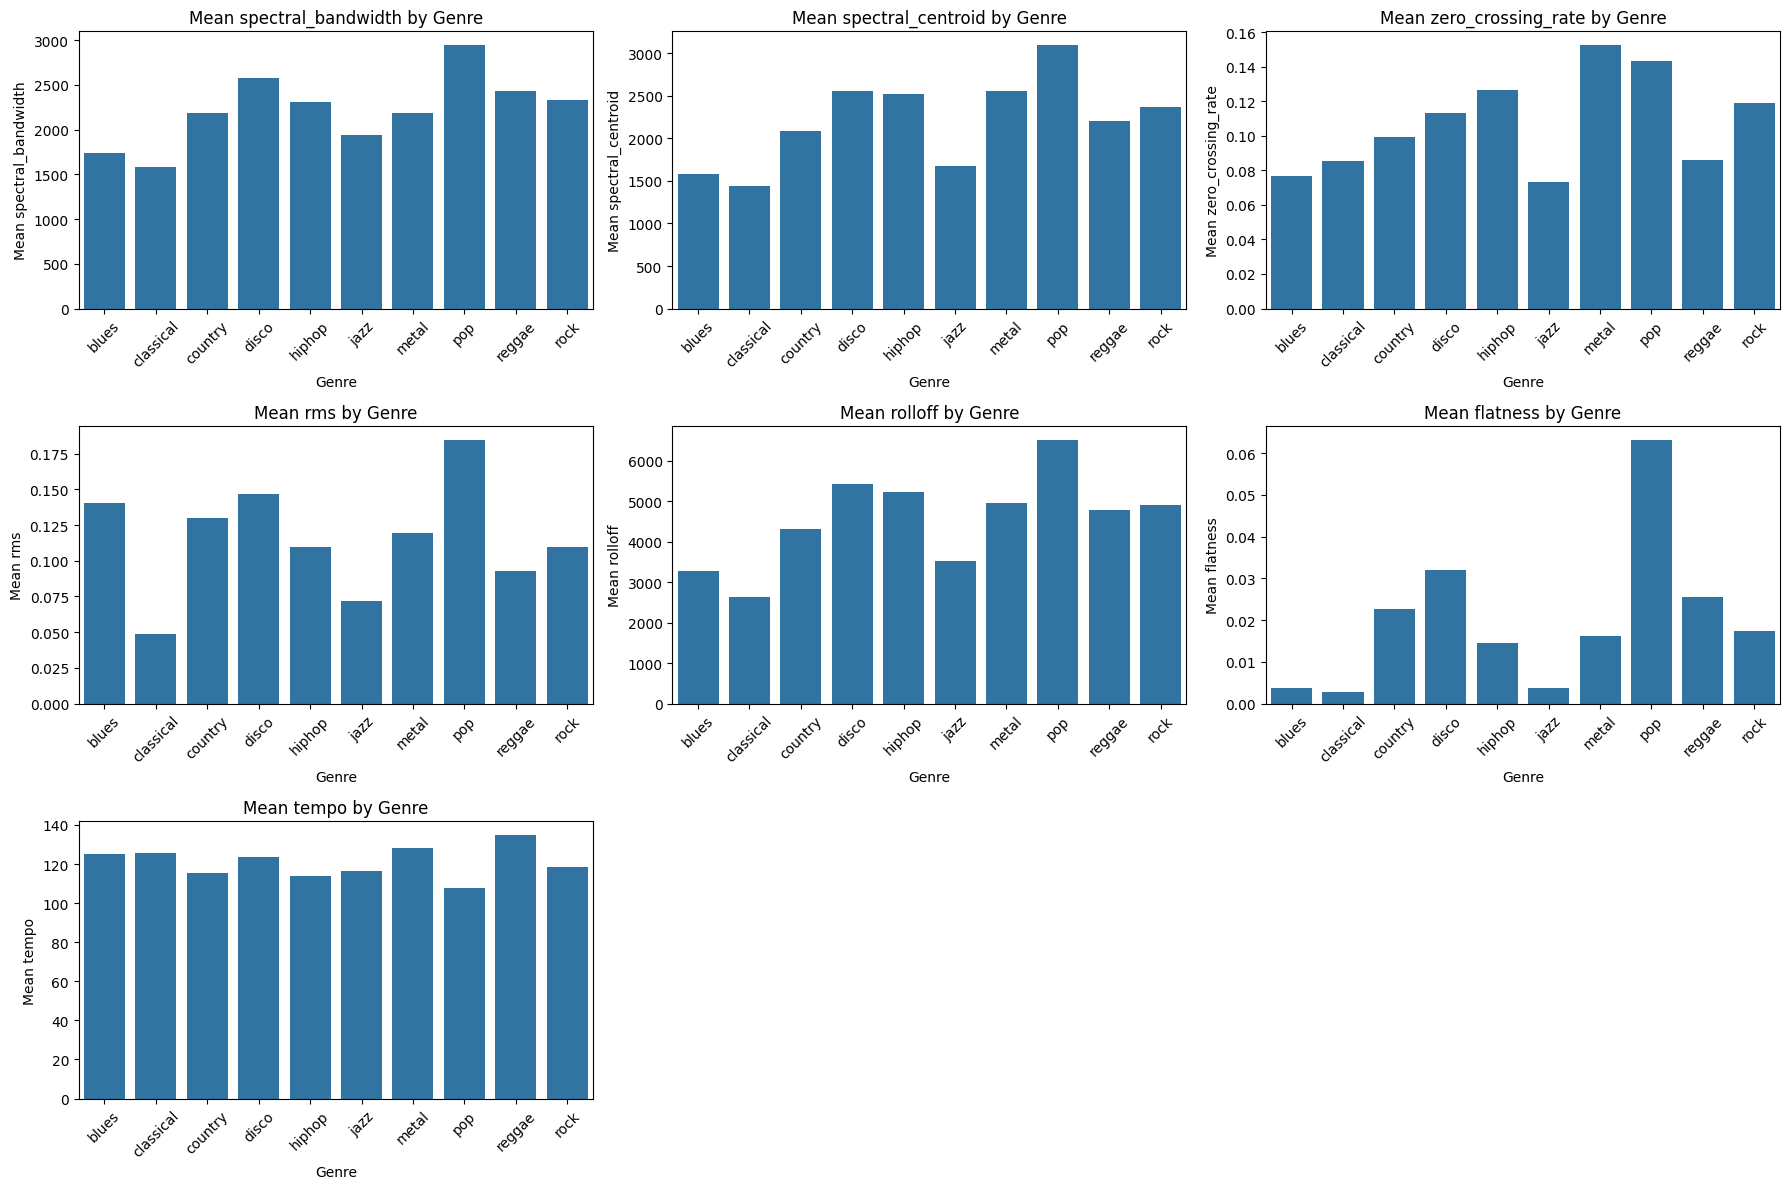

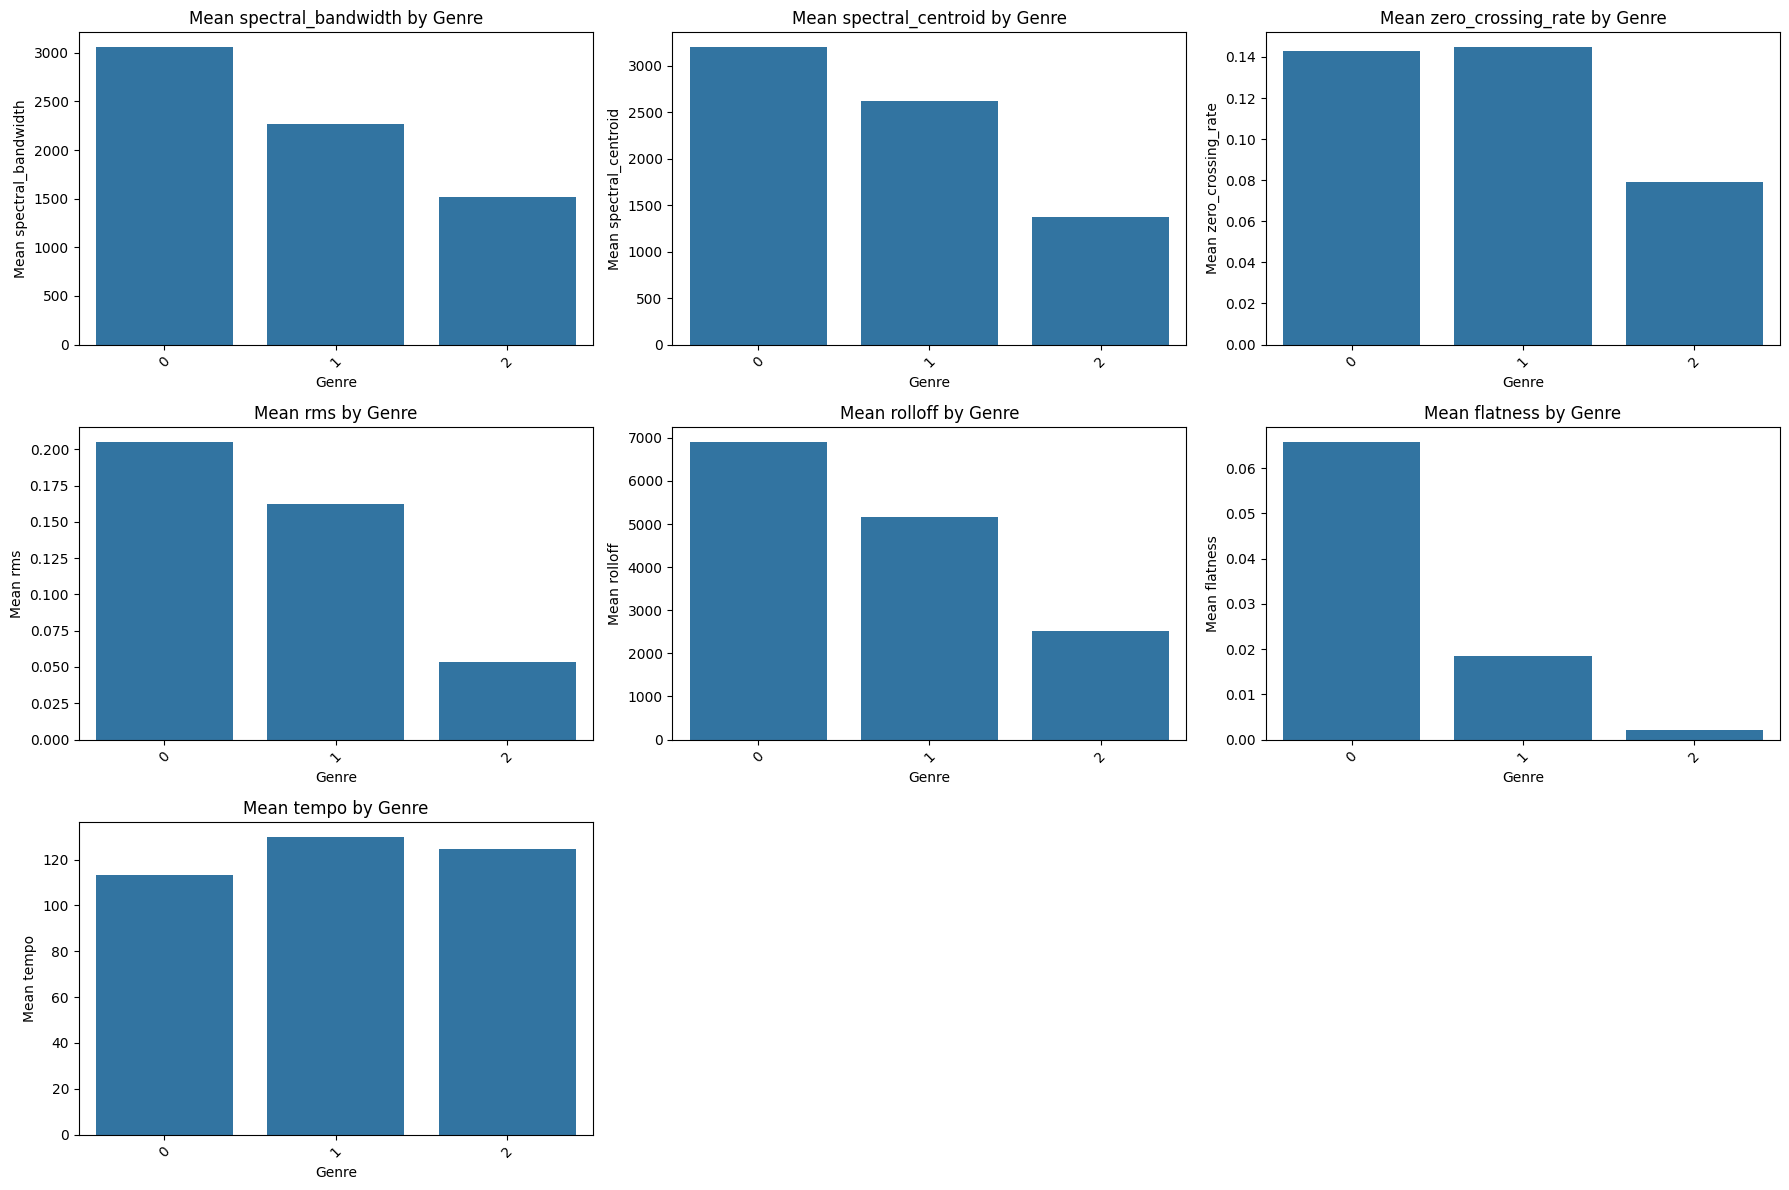

Cluster 0: pop, door cluster 0 te vergelijken met de waarden van de gelabelde genres denken wij dat deze overeenkomt met het genre 'pop'. Dit is vooral te zien aan de 'rolloff' en 'flatness' grafieken.

Cluster 1: metal, door cluster 1 te vergelijken met de waarden van de gelabelde genres denken wij dat deze overeenkomt met het genre 'metal'. Dit is vooral af te leiden uit het 'tempo' en de 'flatness'

Cluster 2: classical, door cluster 2 te vergelijken met de waarden van de gelabelde genres denken wij dat deze overeenkomt met het genre 'classical'. Dit is vooral af te leiden uit de erg lage 'flatness' en 'rms' 

In [85]:
unlabeled_df['genre'] = unlabeled_df['cluster'].map({
    0: 'pop',
    1: 'metal',
    2: 'classical'
})

unlabeled_df.rename(columns={0: 'filename'}, inplace=True)
unlabeled_df.head()

,filename,cluster,genre
0,m00003.wav,1,rock
1,m00012.wav,1,rock
2,m00013.wav,2,classical
3,m00043.wav,1,rock
4,m00044.wav,2,classical


In [87]:
unlabeled_df[['filename', 'genre']].to_csv('kaggle_submission.csv', index=False)

## PCA & NMF

### Clustering met PCA

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


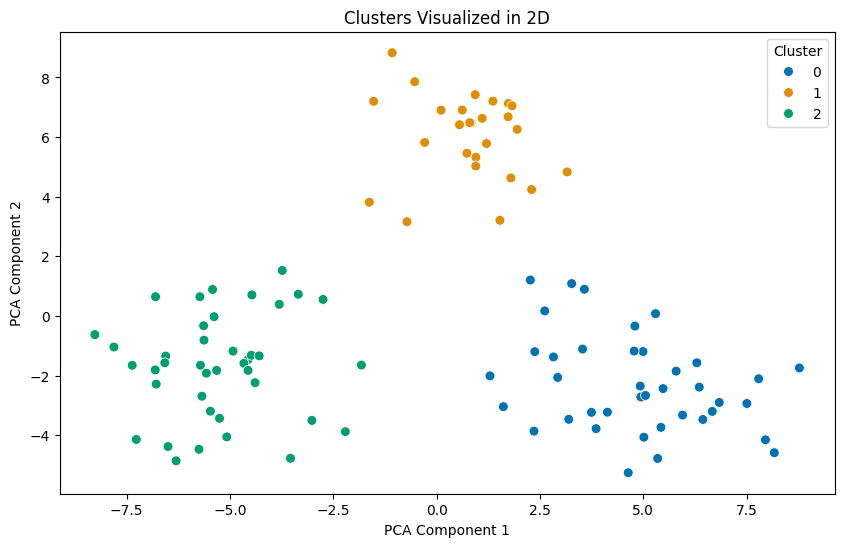

In [104]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='colorblind', s=50)
plt.title('Clusters Visualized in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


PCA. (2025, 9 maart). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


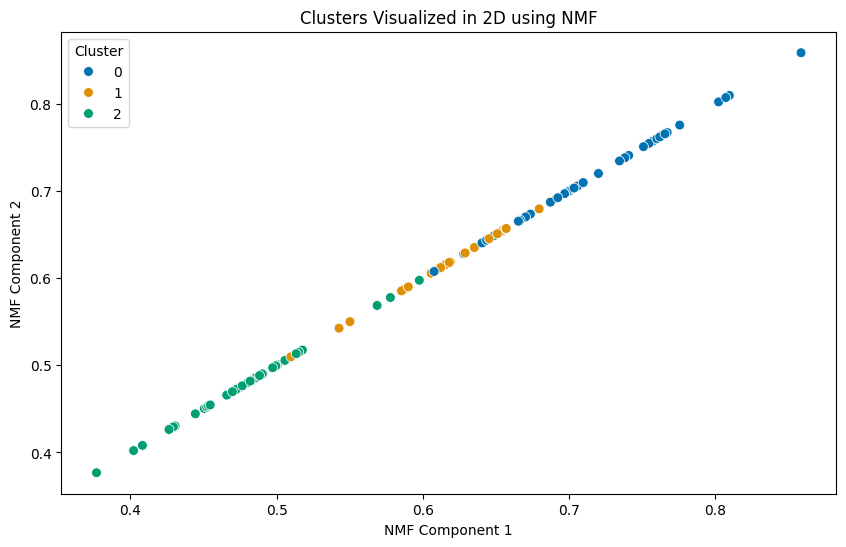

In [109]:
# Scale the data to be non-negative
min_max_scaler = MinMaxScaler()
X_scaled_non_negative = min_max_scaler.fit_transform(X_scaled)

nmf = NMF(n_components=1, random_state=42)
X_nmf = nmf.fit_transform(X_scaled_non_negative)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_nmf[:, 0], y=X_nmf[:, 0], hue=clusters, palette='colorblind', s=50)
plt.title('Clusters Visualized in 2D using NMF')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.legend(title='Cluster')
plt.show()

### Wiskundige werking van PCA en NMF

#### Principal Component Analysis (PCA)

*Werking:*

PCA is een techniek die wordt gebruikt om de dimensies van een dataset te verminderen. Het doel is om de belangrijkste variaties in de data te vinden en deze te projecteren op een nieuwe set assen. Dit helpt om data in hogere dimensies te visualiseren en te analyseren zonder veel informatie te verliezen.

*Stappen:*

1.⁠ ⁠*Normaliseren van de data:* Zorg ervoor dat alle data dezelfde schaal heeft.

2.⁠ ⁠*Berekenen van de covariantiematrix:* Dit laat zien hoe de features variëren ten opzichte van elkaar.

3.⁠ ⁠*Eigendecompositie:* Het berekenen van de eigenwaarden en eigenvectoren van de covariantiematrix. De eigenvectoren geven de richting van de nieuwe assen en de eigenwaarden geven de grootte van de variatie langs deze assen weer.

4.⁠ ⁠*Kiezen van de belangrijkste componenten:* Selecteer de eigenvectoren met de grootste eigenwaarden.

5.⁠ ⁠*Transformeren van de data:* Transformeer de originele data naar de nieuwe assen.

*Voorbeeld:*

Dataset:
$X=$ $\begin{bmatrix}2 & 0 \\0 & 2 \\3 & 1\end{bmatrix}$

1. Standaariseer $X$

2. Bereken de covariantiematrix:
     $\sum_{}$ $=$ $\frac{1}{n-1} X^\top X$

3. Vind de eigenwaarden en eigenvectoren 

4. Selecteer de componenten met de hoogste eigenwaarden.

GeeksforGeeks. (2025, 3 februari). Principal Component Analysis(PCA). GeeksforGeeks. https://www.geeksforgeeks.org/principal-component-analysis-pca/

Lesmateriaal - 24/25 Machine Learning FALL_SEM1. (2025, 9 maart). Brightspace https://brightspace.hhs.nl/d2l/le/lessons/102168/units/874356



#### Non-negative Matrix Factorization

*Werking:*

NMF is een techniek die wordt gebruikt om een niet-negatieve matrix te ontbinden in twee kleinere niet-negatieve matrices. Het doel van NMF is om de originele data te benaderen via een lagere dimensie, wat helpt bij het ontdekken van verborgen patronen.

*Stappen:*

1.⁠ ⁠*Initialiseren van de matrices:* Begin met willekeurige waarden voor de twee kleinere matrices.

2.⁠ ⁠*Optimaliseren van de matrices:* Pas de waarden van de matrices aan om de fout tussen de originele matrix en de benaderde matrix te minimaliseren.

3.⁠ ⁠*Herhalen:* Blijf de matrices aanpassen totdat de fout niet verder vermindert.

*Voorbeeld:*

Matrix:
$\
X = \begin{bmatrix}
4 & 2 \\
1 & 3 \\
5 & 6
\end{bmatrix}
$
1. Stel $(W)$ en $(H)$ in als matrices met kleinere dimensies.
2. Update $(W)$ en $(H)$ iteratief totdat $(||X - WH||)$ voldoende klein is.


GeeksforGeeks. (2025, 7 februari). NonNegative matrix factorization. GeeksforGeeks. https://www.geeksforgeeks.org/non-negative-matrix-factorization/ 

#### Bepalen aantal dimensies

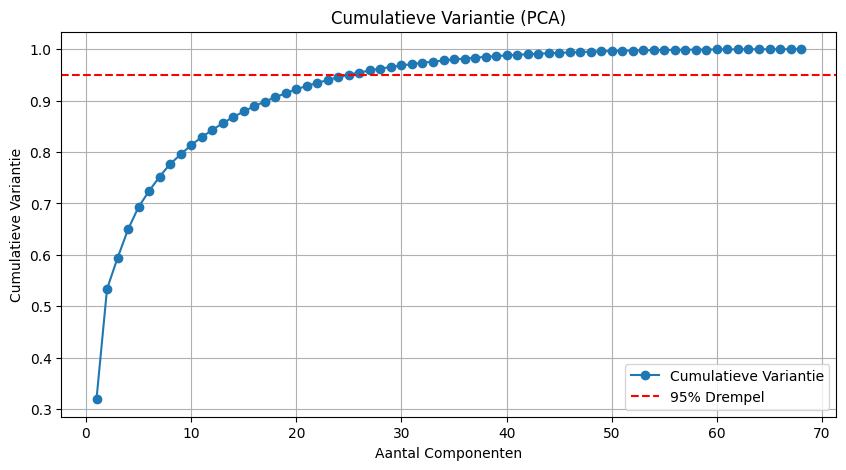

Aantal PCA-componenten voor 95% variantie: 25


In [105]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Visualiseer de cumulatieve variantie
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulatieve Variantie')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Drempel')
plt.title('Cumulatieve Variantie (PCA)')
plt.xlabel('Aantal Componenten')
plt.ylabel('Cumulatieve Variantie')
plt.legend()
plt.grid()
plt.show()

# Bepaal het aantal componenten
n_components_pca = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Aantal PCA-componenten voor 95% variantie: {n_components_pca}")

Voor het bepalen van het aantal dimensies gebruiken wij de cumulatieve variantie. Het optimale aan dimensies/componenten is bereikt wanneer de variantie boven de drempel van 95% komt. In dit geval is dat bij 25.

explained_variance_score. (2025, 9 maart). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html

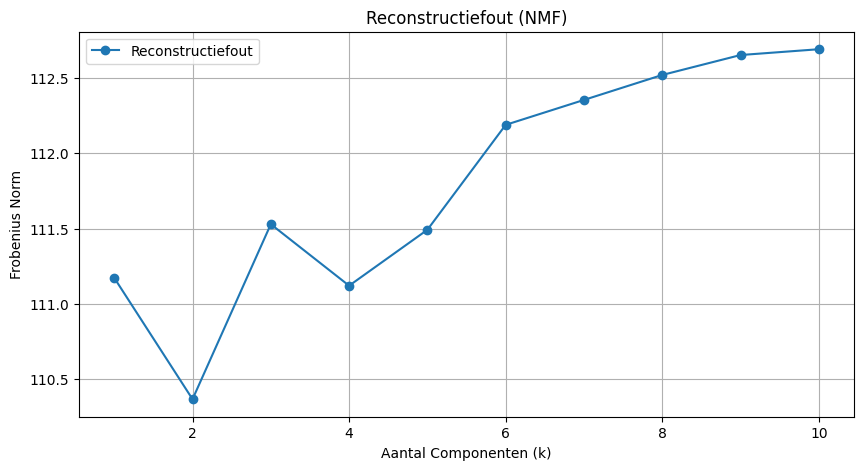

Optimale dimensie voor NMF: 1


In [107]:
errors = []
ks = range(1, 11)

for k in ks:
    nmf = NMF(n_components=k, init='random', random_state=42, max_iter=500)
    W = nmf.fit_transform(np.abs(X_scaled))  # Zorg dat de data niet-negatief is
    H = nmf.components_
    reconstruction = np.dot(W, H)
    error = np.linalg.norm(X_scaled - reconstruction, 'fro')  # Reconstructiefout
    errors.append(error)

# Visualiseer de reconstructiefout
plt.figure(figsize=(10, 5))
plt.plot(ks, errors, marker='o', label='Reconstructiefout')
plt.title('Reconstructiefout (NMF)')
plt.xlabel('Aantal Componenten (k)')
plt.ylabel('Frobenius Norm')
plt.grid()
plt.legend()
plt.show()

# Bepaal het optimale aantal componenten
optimal_k = ks[np.argmin(np.gradient(errors))]
print(f"Optimale dimensie voor NMF: {optimal_k}")

De grafiek toont de reconstructiefout bij verschillende waarden van k. Het optimale aantal componenten k wordt bepaald waar de foutreductie afneemt (trade-off tussen complexiteit en nauwkeurigheid).

NMF. (2025, 9 maart). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

## Maken van een app

In [110]:
def recommend_similar_songs(audio_file, features_df, n_recommendations=5):
    """
    Recommend similar songs based on audio features
    
    Parameters:
    audio_file: str - filename of the target audio file
    features_df: DataFrame - dataframe containing audio features
    n_recommendations: int - number of recommendations to return
    """
    
    
    features = features_df.drop('filename', axis=1)
    
    # scalen voor knn
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    target_idx = features_df[features_df['filename'] == audio_file].index[0]
    
    nn = NearestNeighbors(n_neighbors=n_recommendations+1)  # +1 zodat de nearest neighbor niet het gekozen nummer is
    nn.fit(features_scaled)
    distances, indices = nn.kneighbors(features_scaled[target_idx].reshape(1, -1))
    recommended_files = features_df.iloc[indices[0][1:]]['filename'].tolist()
    
    return recommended_files


def display_recommendations(audio_file, audio_dir):
    """shows the recommendations for a given audio file

    Parameters
    ----------
    audio_file : str
        audio file to recommend similar songs for, filetype required
    audio_dir : str
        directory where the audio files are stored
    """    

    try:
        recommendations = recommend_similar_songs(audio_file, unlabeled_features)
        print(f"\nSimilar songs to {audio_file}:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
        
    
        print("\nOriginal song:")
        display(Audio(filename=os.path.join(Path(audio_dir), audio_file)))
        

        print("\nFirst recommendation:")
        display(Audio(filename=os.path.join(Path(audio_dir), recommendations[0])))
    except ValueError:
        print('Het gekozen bestand is niet gevonden, check of de naam correct is')

Github (2025, 9 maart). Github Copilot [ChatGPT-4o]

In [111]:
display_recommendations('m00055.wav', 'unlabeled')


Similar songs to m00055.wav:
1. m00515.wav
2. m00685.wav
3. m00393.wav
4. m00824.wav
5. m00733.wav

Original song:



First recommendation:


# Opdracht 3: Bevindingen en Conclusie

## Bevindingen

1.⁠ ⁠*Clustering Analyse*
    - Met behulp van de elbow-methode hebben we vastgesteld dat 3 clusters optimaal is voor onze dataset
    - K-means clustering bleek het meest geschikt vanwege de efficiëntie bij grote datasets en de verwachte bolvormige clusters
    - De clusters komen overeen met verschillende muziekgenres: pop, classical en metal

2.⁠ ⁠*Feature Engineering*
    - We hebben diverse audio-features geëxtraheerd waaronder spectrale, ritme en harmonische kenmerken
    - De features lieten duidelijke verschillen zien tussen de muziekgenres
    - MFCC's en chroma features bleken belangrijke onderscheidende kenmerken

3.⁠ ⁠*Dimensionaliteitsreductie*
    - Zowel PCA als NMF zijn toegepast voor visualisatie
    - De clusters waren duidelijk zichtbaar in de 2D-visualisaties
    - PCA liet een betere scheiding zien tussen de clusters dan NMF

## Conclusie

Het project heeft aangetoond dat:

•⁠  ⁠unsupervised learning technieken effectief zijn in het classificeren van muziekgenres

•⁠  ⁠De score van 0.98113 bevestigt de hoge nauwkeurigheid van onze clustering

•⁠  ⁠Het recommender systeem kan succesvol vergelijkbare nummers identificeren op basis van audio-kenmerken

## Bronnenlijst

- Brightspace. (2025, 9 maart). Lesmateriaal - 24/25 Machine Learning FALL_SEM1. https://brightspace.hhs.nl/d2l/le/lessons/102168/units/874356
- GeeksforGeeks. (2025, 15 januari). K means Clustering Introduction. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-clustering-introduction/ 
- GeeksforGeeks. (2025, 4 februari). Hierarchical clustering in machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/hierarchical-clustering/
- GeeksforGeeks. (2025, 29 januari). DBSCAN Clustering in ML | Density based clustering. GeeksforGeeks. https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/ 
- GeeksforGeeks. (2025, 3 februari). Principal Component Analysis(PCA). GeeksforGeeks. https://www.geeksforgeeks.org/principal-component-analysis-pca/ 
- GeeksforGeeks. (2025, 7 februari). NonNegative matrix factorization. GeeksforGeeks. https://www.geeksforgeeks.org/non-negative-matrix-factorization/ 
- GitHub. (2025, 9 maart). GitHub Copilot [ChatGPT-4o]. GitHub.
- Librosa. (2025, 9 maart). Feature Extraction. https://librosa.org/doc/latest/feature.html
- Scikit-Learn. (2025, 9 maart). explained_variance_score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html
- Scikit-Learn. (2025, 9 maart). NMF. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- Scikit-Learn. (2025, 9 maart). PCA. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
